In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Reading Data

In [3]:
df = pd.read_excel('/Users/regan/Desktop/products.xlsx')

In [4]:
# sample product and variation
base_product = 'heart t light holder'
variation_detail = 'colour: white, miscellaneous: hanging'

## Data Preprocessing

In [5]:
df_1 = df[(df['Base Product'] == base_product) & (df['Variation Detail'] == variation_detail)].copy()
low_q = df_1['Quantity'].quantile(0.15)
high_q = df_1['Quantity'].quantile(0.85)
df_1 = df_1[(df_1['Quantity'] >= low_q) & (df_1['Quantity'] <= high_q)]

lstm = df_1.copy()

# Preprocess data
lstm.set_index('Date', inplace=True)
lstm['Logged_Qty'] = np.log1p(lstm['Quantity'])
lstm['Logged_Price'] = np.log1p(lstm['Price'])
lstm = lstm.drop(columns=['Base Product', 'Description', 'Variation Type', 'Variation Detail', 'Material', 'Country', 'Customisation Complexity', 'Price', 'Quantity'], axis=1)

scaler_qty = MinMaxScaler()
scaler = MinMaxScaler()
lstm['Logged_Price'] = scaler.fit_transform(lstm[['Logged_Price']])
lstm['Logged_Qty'] = scaler_qty.fit_transform(lstm[['Logged_Qty']])

lstm.head()

,Logged_Qty,Logged_Price
Date,,
2009-12-04,0.840552,1.00000
2009-12-05,0.512072,0.34002
2009-12-06,0.914808,0.34002
2009-12-09,0.995609,1.00000
2009-12-11,0.975388,1.00000


## Model Training and Prediction

In [13]:
target_variable = 'Logged_Qty'

seq_length=10
epochs=100
batch_size=16

# Define the model
num_features = lstm.shape[1] - 1  # Exclude target from features
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, num_features)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),
    Dense(25),
    Dropout(0.5),
    Dense(1)
])
optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

# Prepare sequential data
def create_sequential_data(dataset, seq_length, target_variable):
    num_samples = len(dataset) - seq_length
    X_data = np.zeros((num_samples, seq_length, num_features))
    y_data = np.zeros(num_samples)
    
    feature_columns = dataset.drop(columns=[target_variable]).values
    target_column = dataset[target_variable].values
    
    for i in range(num_samples):
        X_data[i] = feature_columns[i:i + seq_length]
        y_data[i] = target_column[i + seq_length]
    
    return X_data, y_data

# Create train and test splits
train_data, test_data = train_test_split(lstm, test_size=0.2, shuffle=False)
X_train, y_train = create_sequential_data(train_data, seq_length, target_variable)
X_test, y_test = create_sequential_data(test_data, seq_length, target_variable)

train_dates, test_dates = train_data.index, test_data.index

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Predict and transform predictions
predictions = model.predict(X_test)
predictions = scaler_qty.inverse_transform(predictions)
predictions_unlogged = np.expm1(predictions).flatten()
y_test = scaler_qty.inverse_transform(y_test.reshape(-1, 1))
y_test_unlogged = np.expm1(y_test)

predicted_data = []
for date, actual, pred in zip(test_dates, y_test_unlogged, predictions_unlogged):
    predicted_data.append({
        'Date': date,
        'Actual Quantity': actual,
        'Predicted Quantity': pred
    })

predicted_df = pd.DataFrame(predicted_data)

Epoch 1/100
21/21 [==============================] - 2s 7ms/step - loss: 1.9319
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 1.8134
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 1.5552
Epoch 4/100
21/21 [==============================] - 0s 5ms/step - loss: 1.2996
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 1.3170
Epoch 6/100
21/21 [==============================] - 0s 5ms/step - loss: 1.0913
Epoch 7/100
21/21 [==============================] - 0s 5ms/step - loss: 1.0002
Epoch 8/100
21/21 [==============================] - 0s 5ms/step - loss: 0.9560
Epoch 9/100
21/21 [==============================] - 0s 5ms/step - loss: 0.9235
Epoch 10/100
21/21 [==============================] - 0s 5ms/step - loss: 0.8644
Epoch 11/100
21/21 [==============================] - 0s 5ms/step - loss: 0.7656
Epoch 12/100
21/21 [==============================] - 0s 4ms/step - loss: 0.7424
Epoch 13/100
21/21 [=================

## Model Evaluation

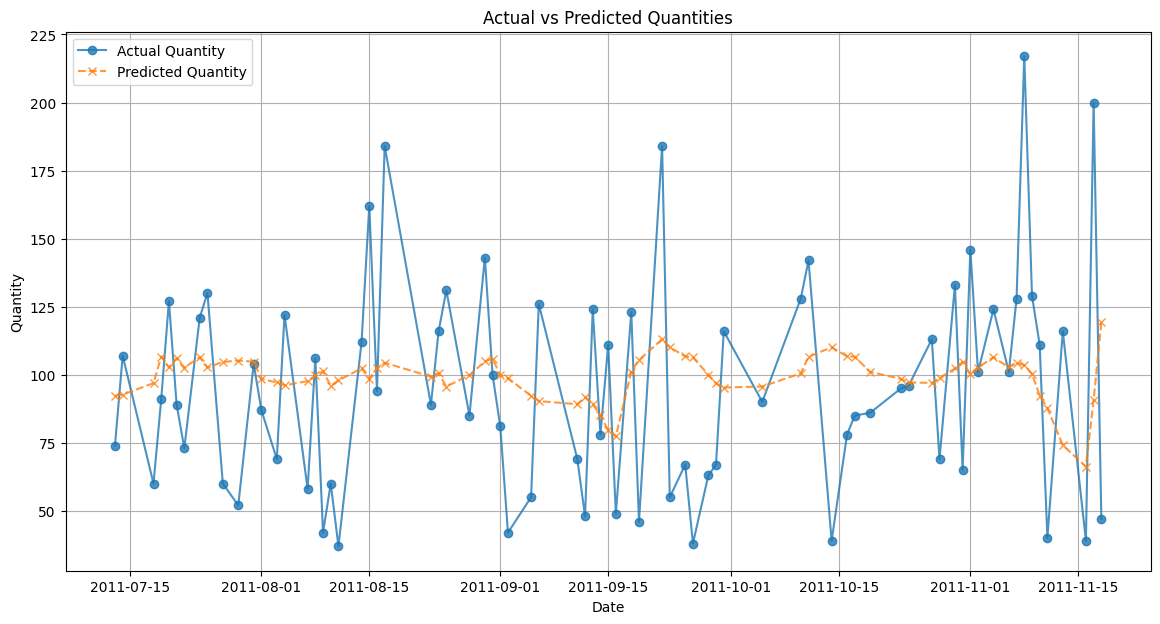

Mean Absolute Error (MAE): 32.5016519165039
Mean Absolute Percentage Error (MAPE): 44.27308546241831%


In [14]:
plt.figure(figsize=(14, 7))
plt.plot(predicted_df['Date'], predicted_df['Actual Quantity'], label='Actual Quantity', marker='o', linestyle='-', alpha=0.8)
plt.plot(predicted_df['Date'], predicted_df['Predicted Quantity'], label='Predicted Quantity', marker='x', linestyle='--', alpha=0.8)
plt.title('Actual vs Predicted Quantities')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

actual = predicted_df['Actual Quantity'].values
predicted = predicted_df['Predicted Quantity'].values

mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")